<a href="https://colab.research.google.com/github/jella/7-days-of-code/blob/main/playstore_sentiment_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Análise de Sentimentos em Avaliações de Aplicativos da Play Store

## Formulação do Problema
Este projeto tem como objetivo classificar avaliações de usuários como **positivas (1)** ou **negativas (0)** com base no conteúdo textual das reviews e na pontuação fornecida (score).

Com isso, é possível automatizar a identificação de experiências insatisfatórias com apps, contribuindo para a melhoria contínua dos produtos disponíveis na Play Store.

o dataset escolhido foi https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews

## Configuração do ambiente

In [112]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string

In [113]:
# É necessário baixar esses pacotes para que o NLTK funcione corretamente.
print("Baixando pacotes do NLTK...")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

Baixando pacotes do NLTK...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Carga do Dataset

In [114]:
url = '/content/reviews.csv'
df = pd.read_csv(url,delimiter=',')
df = df[['content', 'score']]
df

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1
...,...,...
12490,"I really like the planner, it helps me achieve...",5
12491,😁****😁,5
12492,Very useful apps. You must try it,5
12493,Would pay for this if there were even more add...,5


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12495 non-null  object
 1   score    12495 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 195.4+ KB


## Pre-Processamento

### Limpeza e tokenização do Texto

In [116]:
# Inicializações
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
label_encoder = LabelEncoder()

def remover_simbolos(text):
    # Remove apenas símbolos de pontuação ASCII comuns, preserva emojis e letras
    return re.sub(r'[!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~]', '', text)

# Regex para identificar emojis (Unicode básico)
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
    u"\U0001F680-\U0001F6FF"  # transporte e mapas
    u"\U0001F1E0-\U0001F1FF"  # bandeiras
    "]+", flags=re.UNICODE
)

# Cria a variável de sentimento (positivo/negativo)
def classify_sentiment(score):
    return 1 if score >= 4 else 0  # 1 = positivo, 0 = negativo

# Remove avaliações neutras (score == 3)
df = df[df['score'] != 3].copy()

df['sentiment'] = df['score'].apply(classify_sentiment)

def preprocessar_texto(text):

    # Garante que é string válida, mesmo que venha NaN ou float
    text = str(text) if isinstance(text, str) else ''

    text = text.lower()

    # 1. Remover HTML e URLs
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)

    # 2. Remover símbolos indesejados (como *)
    text = remover_simbolos(text)

    # 3. Colocar espaço ao redor de emojis
    text = emoji_pattern.sub(lambda m: f' {m.group()} ', text)

    # 4. Tokenização (mantém emojis isolados)  manter emoji que importante para analise de sentimento
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())

    # 5. Filtro: stopwords e números
    tokens = [t for t in tokens if t not in stop_words and not t.isdigit()]

    # 6. Lematizar apenas palavras
    tokens = [lemmatizer.lemmatize(t) if t.isalpha() else t for t in tokens]

    return ' '.join(tokens)

# Aplicação segura
if 'content' in df.columns:
    df.dropna(subset=['content'], inplace=True)
    df = df[df['score'] != 3].copy()
    df['content'] = df['content'].apply(preprocessar_texto)
    df['target'] = label_encoder.fit_transform(df['sentiment'])
    df = df[['content', 'target']]
df

,content,target
0,cannot open app anymore,0
1,begging refund app month nobody replying,0
2,costly premium version approx indian rupee per...,0
3,used keep organized update made mess thing cud...,0
4,dan birthday oct,0
...,...,...
12490,really like planner help achieve task goal ave...,1
12491,😁 😁,1
12492,useful apps must try,1
12493,would pay even addition update absolutely love...,1


## Separação em conjunto de treino e conjunto de teste com holdout

In [117]:
X = df['content']  # textos pré-processados
y = df['target']  # rótulos (0 ou 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% para teste, 80% para treino
    random_state=42,      # garante reprodutibilidade
    stratify=y            # mantém proporção das classes
)

## Vetorização

In [118]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Criação e avaliação de modelos: linha base

Naive Bayes: F1-score médio = 0.8403
SVM: F1-score médio = 0.8277
Árvore: F1-score médio = 0.7458
KNN: F1-score médio = 0.6388


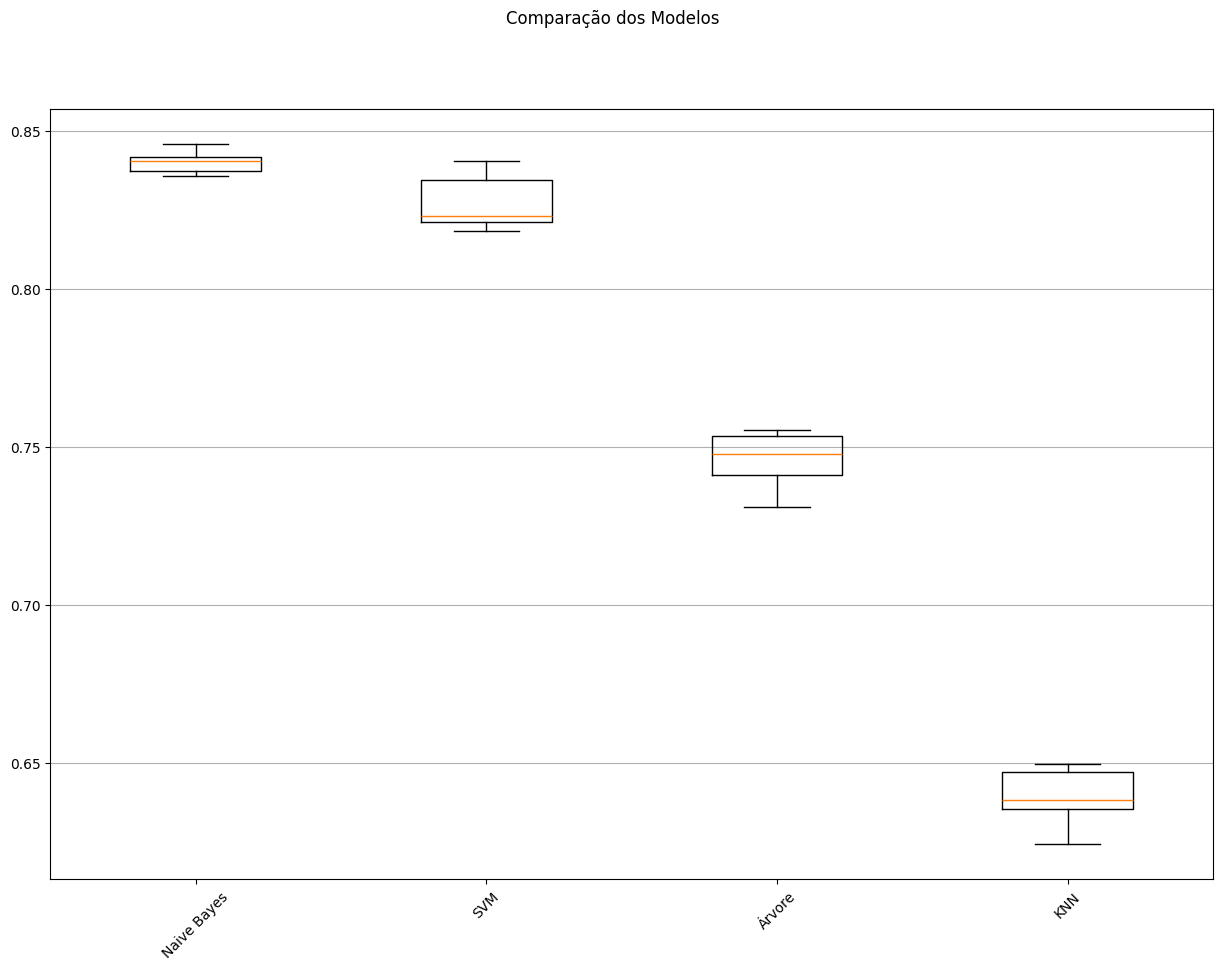

In [119]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Árvore': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Listas para armazenar os resultados
import matplotlib.pyplot as plt

results = []
names = []


for name, model in models.items():
    score = cross_val_score(model, X_train_vec, y_train, cv=5, scoring='accuracy')
    print(f"{name}: F1-score médio = {score.mean():.4f}")
    results.append(score)
    names.append(name)


# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.yaxis.grid(True)
plt.xticks(rotation=45)
plt.show()

## Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.839 (0.005)
KNN-orig: 0.633 (0.003)
CART-orig: 0.758 (0.013)
NB-orig: 0.841 (0.007)
SVM-orig: 0.834 (0.003)
LR-padr: 0.823 (0.005)
KNN-padr: 0.690 (0.004)
CART-padr: 0.758 (0.007)
NB-padr: 0.821 (0.006)
SVM-padr: 0.820 (0.001)
LR-norm: 0.839 (0.005)
KNN-norm: 0.657 (0.007)
CART-norm: 0.758 (0.006)
NB-norm: 0.841 (0.007)
SVM-norm: 0.834 (0.003)


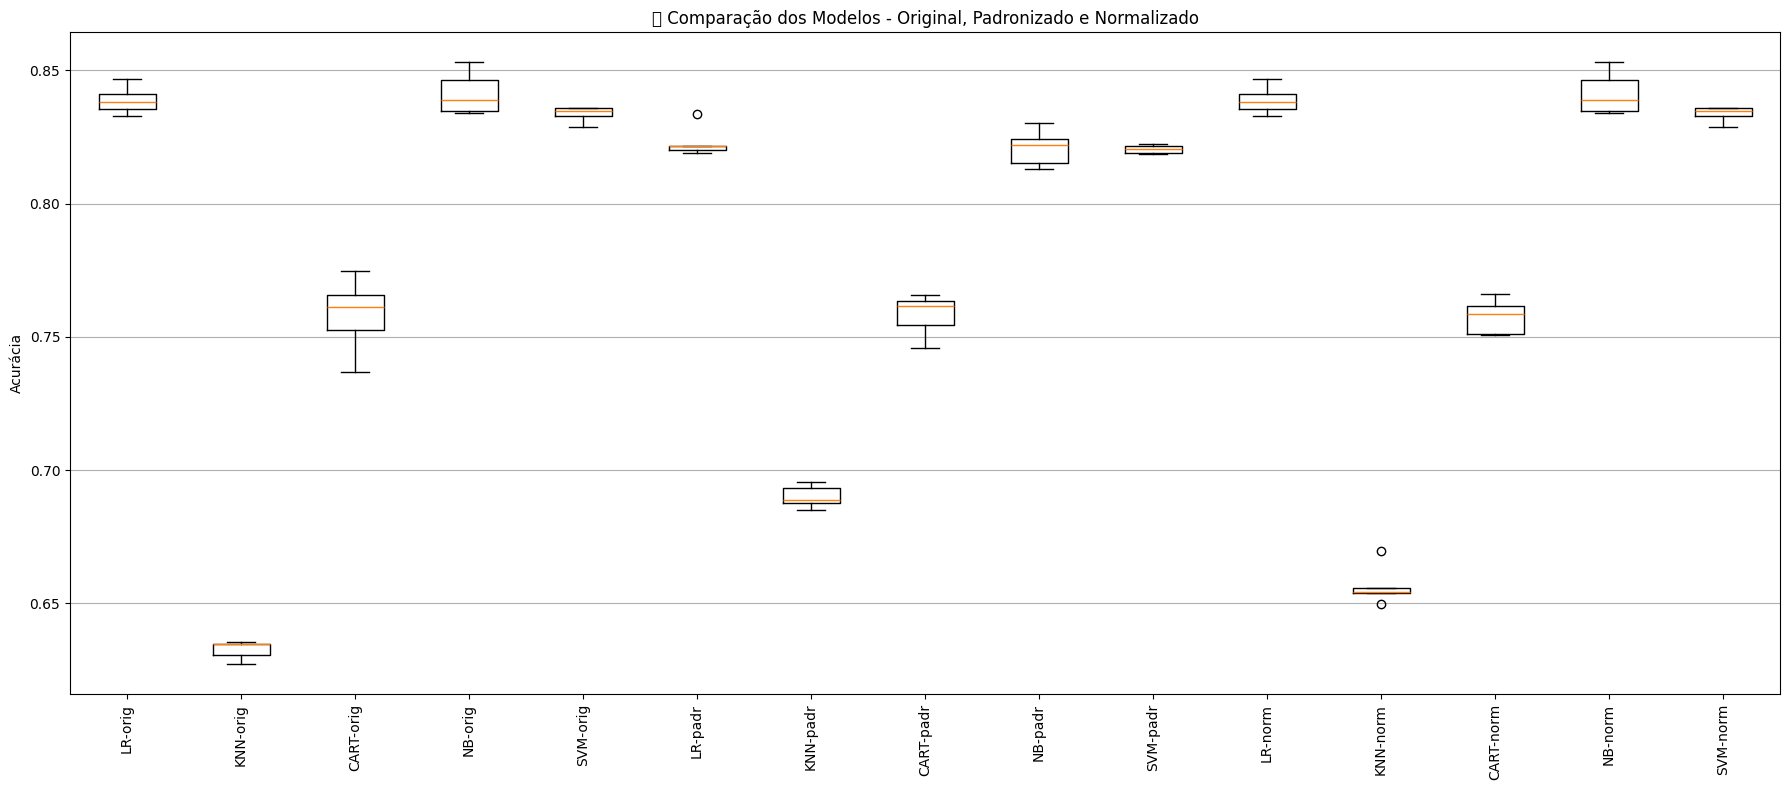

In [120]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Configurações
np.random.seed(42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'accuracy'

# Modelos a avaliar
modelos = [
    ('LR', LogisticRegression(max_iter=200)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', MultinomialNB()),
    ('SVM', LinearSVC(max_iter=10000))
]

# Transformações a aplicar
transformacoes = {
    'orig': None,
    'padr': StandardScaler(with_mean=False),
    'norm': Normalizer()
}

# Vetorizar o texto
df['content'] = df['content'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
X_text = df['content']
y = df['target']

vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X_text)

# Executar todos os pipelines
results = []
names = []

for trans_nome, transformador in transformacoes.items():
    if transformador is not None:
        X_proc = transformador.fit_transform(X_tfidf.toarray())
    else:
        X_proc = X_tfidf

    for nome, modelo in modelos:
        pipeline_name = f"{nome}-{trans_nome}"
        try:
            cv_result = cross_val_score(modelo, X_proc, y, cv=kfold, scoring=scoring)
            results.append(cv_result)
            names.append(pipeline_name)
            print(f"{pipeline_name}: {cv_result.mean():.3f} ({cv_result.std():.3f})")
        except Exception as e:
            print(f"Erro em {pipeline_name}: {e}")

# Gráfico comparativo
plt.figure(figsize=(18, 8))
plt.boxplot(results)
plt.title('📊 Comparação dos Modelos - Original, Padronizado e Normalizado')
plt.xticks(ticks=np.arange(1, len(names) + 1), labels=names, rotation=90)
plt.ylabel('Acurácia')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


OBS:

No scikit-learn, a **A normalização L2** já é aplicada por padrão no TfidfVectorizer, tornando desnecessária qualquer normalização adicional a jusante do pipeline.

**Padronização (standardization)** geralmente não oferece ganhos significativos para modelos lineares que utilizam features TF-IDF. Isso acontece porque os valores de TF-IDF já possuem uma escala relativa e consistente por sua própria natureza.

### Otimização dos hiperparâmetros

In [108]:
# Logistic Regression
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', LogisticRegression(max_iter=1000))
])
param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 3],
    'tfidf__max_df': [0.9, 0.95]
}

# MultinomialNB
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', MultinomialNB())
])
param_nb = {
    'clf__alpha': [0.01, 0.1, 1, 10],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 3],
    'tfidf__max_df': [0.9, 0.95]
}

# LinearSVC
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', LinearSVC(max_iter=10000))
])
param_svc = {
    'clf__C': [0.01, 0.1, 1, 10],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 3],
    'tfidf__max_df': [0.9, 0.95]
}

# Logistic Regression
print("🔍 Otimizando Logistic Regression...")
gs_lr = GridSearchCV(pipe_lr, param_lr, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gs_lr.fit(X, y)
print("Melhor score LR:", gs_lr.best_score_)
print("Melhores params LR:", gs_lr.best_params_)

# Naive Bayes
print("\n🔍 Otimizando Naive Bayes...")
gs_nb = GridSearchCV(pipe_nb, param_nb, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gs_nb.fit(X, y)
print("Melhor score NB:", gs_nb.best_score_)
print("Melhores params NB:", gs_nb.best_params_)

# SVM
print("\n🔍 Otimizando SVM...")
gs_svc = GridSearchCV(pipe_svc, param_svc, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
gs_svc.fit(X, y)
print("Melhor score SVM:", gs_svc.best_score_)
print("Melhores params SVM:", gs_svc.best_params_)


🔍 Otimizando Logistic Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Melhor score LR: 0.8393943473629337
Melhores params LR: {'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}

🔍 Otimizando Naive Bayes...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Melhor score NB: 0.8429159810521067
Melhores params NB: {'clf__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

🔍 Otimizando SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Melhor score SVM: 0.8364429636680946
Melhores params SVM: {'clf__C': 0.1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


## Finalização do Modelo

In [109]:
# Pipeline com TF-IDF + Naive Bayes
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Grid de hiperparâmetros para otimização
param_grid_nb = {
    'tfidf__max_df': [0.7, 0.9],
    'tfidf__min_df': [1, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.5, 1, 2]
}

# Busca com validação cruzada
gs_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
gs_nb.fit(X_train, y_train)

# Exibe os melhores parâmetros
print("Melhor score NB:", gs_nb.best_score_)
print("Melhores params NB:", gs_nb.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhor score NB: 0.8583834027364663
Melhores params NB: {'clf__alpha': 0.5, 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


## Salvando os arquivos

In [110]:
# Salvar modelo treinado
joblib.dump(gs_nb.best_estimator_, 'modelo_nb_otimizado.joblib')

# Salvar também o LabelEncoder (caso esteja usando)
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

## Simulando a aplicação do modelo em dados não vistos

In [111]:
# Carrega modelo e encoder
modelo = joblib.load('modelo_nb_otimizado.joblib')
encoder = joblib.load('label_encoder.joblib')

# Função de predição
def prever_sentimento(texto):
    texto_processado = preprocessar_texto(texto)
    pred = modelo.predict([texto_processado])
    return encoder.inverse_transform(pred)[0]

# Exemplos de uso
ex1 = "😍😍😍😍😍😍😍😍😍"
ex2 = "I hate this app, it's full of bugs 😡"

print("Exemplo 1:", prever_sentimento(ex1))  # Esperado: 'positivo'
print("Exemplo 2:", prever_sentimento(ex2))  # Esperado: 'negativo'

Exemplo 1: 1
Exemplo 2: 0


O modelo desenvolvido demonstrou ser eficaz na tarefa de classificar avaliações em inglês da Play Store como positivas ou negativas, utilizando exclusivamente o texto fornecido pelos usuários. A abordagem envolveu etapas clássicas de pré-processamento, vetorização com TF-IDF e experimentação com diversos algoritmos de classificação supervisionada.

Entre os algoritmos avaliados, o Naive Bayes combinado com TF-IDF se destacou pelo melhor equilíbrio entre desempenho, simplicidade e eficiência computacional. Esse modelo alcançou resultados consistentes, tornando-se uma escolha sólida para aplicações como MVPs, protótipos ou sistemas embarcados, onde o custo computacional é uma restrição relevante.

Por outro lado, observou-se que abordagens clássicas apresentam limitações ao lidar com nuances linguísticas mais complexas — como ambiguidade, ironia e gírias. Nessas situações, modelos de linguagem mais modernos, como os baseados em transformers (ex: BERT, RoBERTa), tendem a oferecer resultados superiores, porém com maior demanda de recursos e complexidade de implementação.

De modo geral, o projeto evidencia que técnicas tradicionais de NLP ainda têm espaço e podem entregar valor real em cenários práticos, especialmente na automação da triagem de feedbacks de usuários, contribuindo para decisões de produto mais ágeis e embasadas.

